In [49]:
'''
Forecasting Setup Summary
Granularity: family + store
Baseline Model: Prophet
Other Models to Try Later: SARIMA, XGBoost, Deep Learning (LSTM/TFT)
External Regressors: onpromotion, is_holiday, month, day_of_week dummies
'''

'\nForecasting Setup Summary\nGranularity: family + store\nBaseline Model: Prophet\nOther Models to Try Later: SARIMA, XGBoost, Deep Learning (LSTM/TFT)\nExternal Regressors: onpromotion, is_holiday, month, day_of_week dummies\n'

# FORECASTING

In [50]:
from prophet import Prophet
import warnings
warnings.filterwarnings("ignore")

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the cleaned training dataset
df = pd.read_csv("../data/processed/cleaned_train.csv", parse_dates=["date"])

# Drop unneeded columns
df = df.drop(columns=["id", "dcoilwtico", "dcoilwtico_x", "city", "state", "type", "cluster"])

# Confirm structure
df.head()


,date,store_nbr,family,sales,onpromotion,transactions,is_perishable,shelf_life_days,sales_per_transaction,transactions_missing,zero_sales,day_of_week,month,week,year,is_weekend,is_month_start,is_month_end,is_holiday
0,2013-01-02,1,AUTOMOTIVE,2.0,0,2111.0,0,365,0.000947,0,0,2,1,1,2013,0,0,0,0
1,2013-01-02,1,BABY CARE,0.0,0,2111.0,0,180,0.000000,0,1,2,1,1,2013,0,0,0,0
2,2013-01-02,1,BEAUTY,2.0,0,2111.0,0,365,0.000947,0,0,2,1,1,2013,0,0,0,0
3,2013-01-02,1,BEVERAGES,1091.0,0,2111.0,0,120,0.516817,0,0,2,1,1,2013,0,0,0,0
4,2013-01-02,1,BOOKS,0.0,0,2111.0,0,365,0.000000,0,1,2,1,1,2013,0,0,0,0


# Scope & Scalability of Forecasting Pipeline
To ensure efficient use of local compute resources, Time series forecasting is scoped to the top 4 high-performing stores and top 4 highest-volume product families, based on cumulative sales. The entire pipeline is modular and scalable — built to handle all 50+ stores and 30+ families via batch processing or cloud-based deployment.

## Using PROPHET as our baseline model

In [52]:


# Aggregate + Feature Setup (Single Store-Family)

# Select one store-family combo for testing
store_id = 1
family_id = "GROCERY I"
example = df[(df["store_nbr"] == store_id) & (df["family"] == family_id)].copy()

# Rename for Prophet
example.rename(columns={"date": "ds", "sales": "y"}, inplace=True)

# Select useful external regressors
regressors = [
    "onpromotion", "transactions", "is_perishable", "shelf_life_days",
    "sales_per_transaction", "transactions_missing", "zero_sales",
    "day_of_week", "month", "week", "is_weekend", "is_month_start", "is_month_end", "is_holiday"
]

# Ensure we retain only required columns for Prophet
prophet_df = example[["ds", "y"] + regressors].copy()


In [53]:
prophet_df

,ds,y,onpromotion,transactions,is_perishable,shelf_life_days,sales_per_transaction,transactions_missing,zero_sales,day_of_week,month,week,is_weekend,is_month_start,is_month_end,is_holiday
12,2013-01-02,2652.0,0,2111.0,0,90,1.256277,0,0,2,1,1,0,0,0,0
1794,2013-01-03,2121.0,0,1833.0,0,90,1.157119,0,0,3,1,1,0,0,0,0
3576,2013-01-04,2056.0,0,1863.0,0,90,1.103596,0,0,4,1,1,0,0,0,0
5358,2013-01-05,2216.0,0,1509.0,0,90,1.468522,0,0,5,1,1,1,0,0,1
7140,2013-01-06,723.0,0,520.0,0,90,1.390385,0,0,6,1,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2983080,2017-08-11,1270.0,24,570.0,0,90,2.228070,0,0,4,8,32,0,0,0,0
2984862,2017-08-12,1630.0,28,1004.0,0,90,1.623506,0,0,5,8,32,1,0,0,0
2986644,2017-08-13,952.0,19,416.0,0,90,2.288462,0,0,6,8,32,1,0,0,0
2988426,2017-08-14,2407.0,30,1733.0,0,90,1.388921,0,0,0,8,33,0,0,0,0


11:37:07 - cmdstanpy - INFO - Chain [1] start processing
11:37:09 - cmdstanpy - INFO - Chain [1] done processing


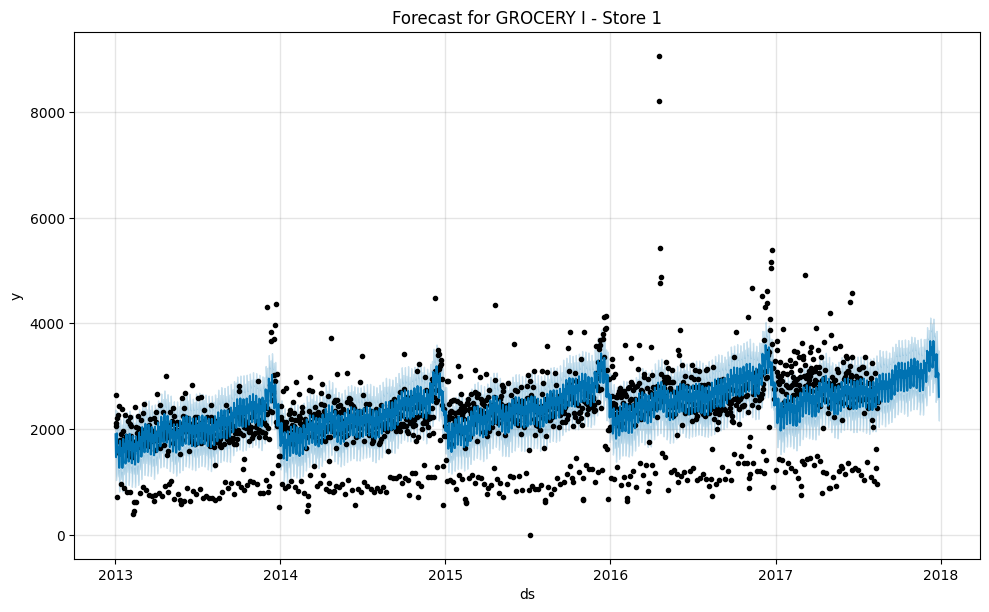

In [54]:
# Training Prophet Model

# Initialize Prophet and add regressors
model = Prophet()

for reg in regressors:
    model.add_regressor(reg)

# Fit model
model.fit(prophet_df)

# Extend into future (e.g., 135 days)
future = model.make_future_dataframe(periods=135)

# Add regressors to future dataframe
# We'll just extend the last known values for simplicity (you can add real future values if known)
latest_values = prophet_df[regressors].iloc[-1]
for reg in regressors:
    future[reg] = latest_values[reg]

# Predict
forecast = model.predict(future)

# Plot
model.plot(forecast)
plt.title(f"Forecast for {family_id} - Store {store_id}")
plt.show()


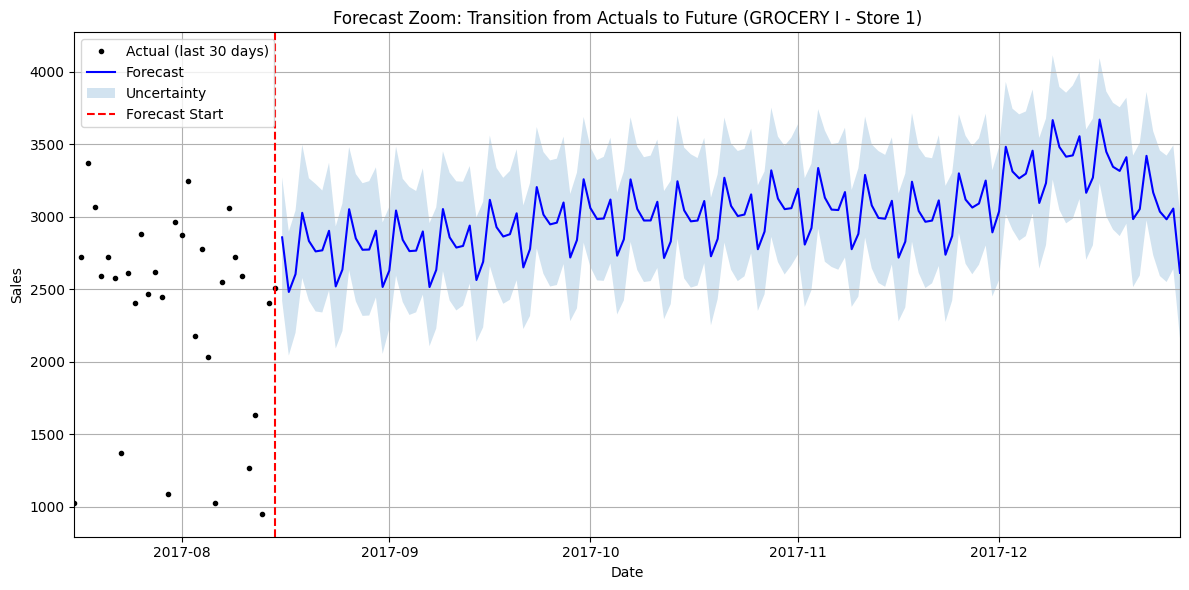

In [55]:
# Set the forecast start point
last_date = prophet_df['ds'].max()
start_window = last_date - pd.Timedelta(days=30)  # 1 month before last date
end_window = forecast['ds'].max()  # Last date in forecast (30 days into the future)

# Prepare actuals and forecasted values in the window
actual_recent = prophet_df[(prophet_df['ds'] >= start_window) & (prophet_df['ds'] <= last_date)]
future_only = forecast[(forecast['ds'] > last_date) & (forecast['ds'] <= end_window)]

# Combine for plotting
combined = pd.concat([
    actual_recent[['ds', 'y']].rename(columns={'y': 'actual'}),
    future_only[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
], axis=0)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(actual_recent['ds'], actual_recent['y'], 'k.', label='Actual (last 30 days)')
plt.plot(future_only['ds'], future_only['yhat'], 'b-', label='Forecast')
plt.fill_between(future_only['ds'], future_only['yhat_lower'], future_only['yhat_upper'], alpha=0.2, label='Uncertainty')
plt.axvline(x=last_date, color='r', linestyle='--', label='Forecast Start')
plt.xlim([start_window, end_window])
plt.title(f"Forecast Zoom: Transition from Actuals to Future ({family_id} - Store {store_id})")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



##### The model anticipates continued growth with moderate uncertainty, reflecting consistent store performance post-holiday.

In [56]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Join with actuals
results = prophet_df[['ds', 'y']].merge(forecast[['ds', 'yhat']], on='ds', how='left')

# Drop future values for now
results = results.dropna()

# Metrics
mae = mean_absolute_error(results['y'], results['yhat'])
rmse = np.sqrt(mean_squared_error(results['y'], results['yhat']))
print(f"MAE: {mae:.2f} | RMSE: {rmse:.2f}")


MAE: 525.49 | RMSE: 750.11


##### The model performs reasonably well for a baseline, but higher RMSE indicates occasional under- or overestimation on peak days.

### Improving Errors

11:37:11 - cmdstanpy - INFO - Chain [1] start processing
11:37:12 - cmdstanpy - INFO - Chain [1] done processing


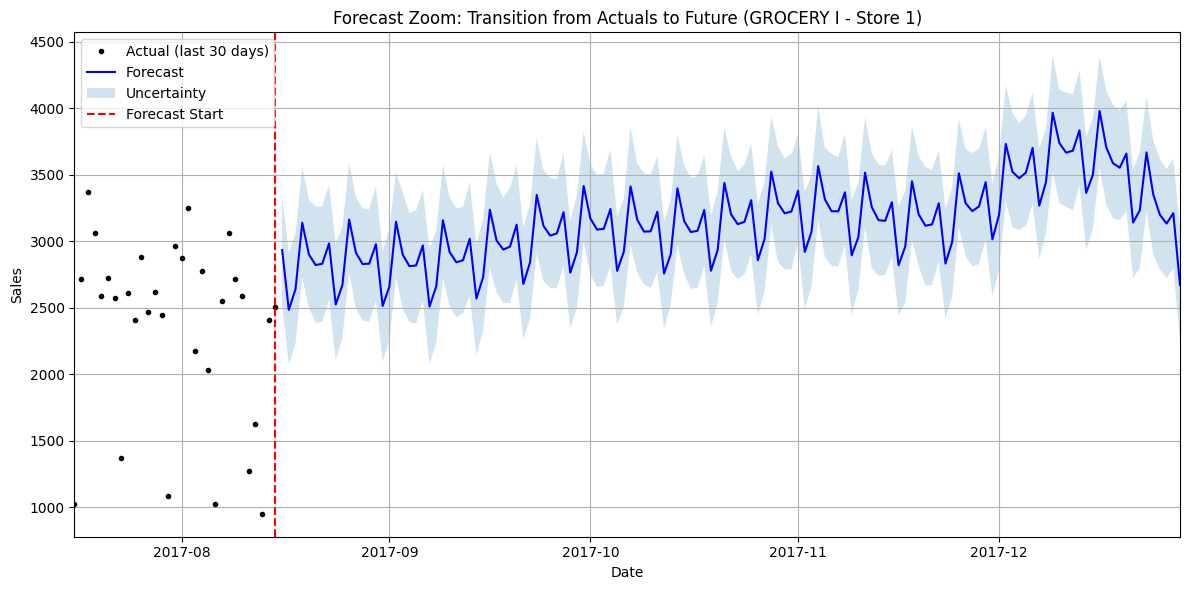

MAE: 531.06 | RMSE: 748.51


In [57]:
# Hyperparameter Tuning in Prophet
## Weekly pattern is strong, upward trend is present, and Prophet defaults to additive seasonality which may underfit amplitude shifts

# Updated Prophet model with tuned parameters
model = Prophet(
    seasonality_mode='multiplicative',
    changepoint_prior_scale=0.1,
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False
)

# Add all external regressors
for reg in regressors:
    model.add_regressor(reg)

# Fit model
model.fit(prophet_df)

# Extend into future (e.g., 135 days)
future = model.make_future_dataframe(periods=135)

# Add regressors to future dataframe
# We'll just extend the last known values for simplicity (you can add real future values if known)
latest_values = prophet_df[regressors].iloc[-1]
for reg in regressors:
    future[reg] = latest_values[reg]

# Predict
forecast = model.predict(future)

# Set the forecast start point
last_date = prophet_df['ds'].max()
start_window = last_date - pd.Timedelta(days=30)  # 1 month before last date
end_window = forecast['ds'].max()  # Last date in forecast (30 days into the future)

# Prepare actuals and forecasted values in the window
actual_recent = prophet_df[(prophet_df['ds'] >= start_window) & (prophet_df['ds'] <= last_date)]
future_only = forecast[(forecast['ds'] > last_date) & (forecast['ds'] <= end_window)]

# Combine for plotting
combined = pd.concat([
    actual_recent[['ds', 'y']].rename(columns={'y': 'actual'}),
    future_only[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
], axis=0)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(actual_recent['ds'], actual_recent['y'], 'k.', label='Actual (last 30 days)')
plt.plot(future_only['ds'], future_only['yhat'], 'b-', label='Forecast')
plt.fill_between(future_only['ds'], future_only['yhat_lower'], future_only['yhat_upper'], alpha=0.2, label='Uncertainty')
plt.axvline(x=last_date, color='r', linestyle='--', label='Forecast Start')
plt.xlim([start_window, end_window])
plt.title(f"Forecast Zoom: Transition from Actuals to Future ({family_id} - Store {store_id})")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Join with actuals
results = prophet_df[['ds', 'y']].merge(forecast[['ds', 'yhat']], on='ds', how='left')

# Drop future values for now
results = results.dropna()

# Metrics
mae = mean_absolute_error(results['y'], results['yhat'])
rmse = np.sqrt(mean_squared_error(results['y'], results['yhat']))
print(f"MAE: {mae:.2f} | RMSE: {rmse:.2f}")

#### Forecasting using PROPHET for Top 4 Store-Family pairs

In [ ]:
import os

# Load data
df = pd.read_csv("../data/processed/cleaned_train.csv", parse_dates=["date"])

# Drop unused cols
df.drop(columns=["id", "dcoilwtico", "dcoilwtico_x", "city", "state", "type", "cluster"], inplace=True)

# Rename for Prophet
df.rename(columns={"date": "ds", "sales": "y"}, inplace=True)

# Store all error metrics here
results_list = []

# Directory for saving forecasts/plots
os.makedirs("forecasts", exist_ok=True)
os.makedirs("plots", exist_ok=True)

# Calculate total sales per store and family
top_stores = df.groupby("store_nbr")["y"].sum().nlargest(4).index.tolist()
top_families = df.groupby("family")["y"].sum().nlargest(4).index.tolist()

# Filter dataset for top store-family pairs
df_subset = df[df["store_nbr"].isin(top_stores) & df["family"].isin(top_families)].copy()


# Looping through the Top 4 Store-Family pairs (High-Performing)

store_families = df_subset.groupby(['store_nbr', 'family'])

for (store, family), group in store_families:
    try:
        data = group.sort_values("ds").copy()
        
        # Drop rows with NaN regressors
        data = data.dropna().reset_index(drop=True)
        
        # Feature list
        regressors = [
            "onpromotion", "transactions", "is_perishable", "shelf_life_days",
            "sales_per_transaction", "transactions_missing", "zero_sales",
            "day_of_week", "month", "week", "is_weekend", "is_month_start", "is_month_end", "is_holiday"
        ]
        
        # Subset
        prophet_df = data[["ds", "y"] + regressors]
        
        # Build model
        model = Prophet(
            seasonality_mode='multiplicative',
            changepoint_prior_scale=0.1,
            yearly_seasonality=True,
            weekly_seasonality=True,
            daily_seasonality=False
        )
        
        for reg in regressors:
            model.add_regressor(reg)
        
        model.fit(prophet_df)
        
        # Saving the model

        import joblib
        model_dir = "models"
        os.makedirs(model_dir, exist_ok=True)
        model_filename = f"{model_dir}/prophet_model_{store}_{family}.pkl"
        joblib.dump(model, model_filename)

        # Forecast horizon
        future = model.make_future_dataframe(periods=140)
        
        # Use last row of known regressors for forecasting period
        latest_vals = prophet_df[regressors].iloc[-1]
        for reg in regressors:
            future[reg] = latest_vals[reg]
        
        forecast = model.predict(future)
        
        # Evaluation on historical only
        merged = prophet_df[['ds', 'y']].merge(forecast[['ds', 'yhat']], on='ds')
        mae = mean_absolute_error(merged['y'], merged['yhat'])
        rmse = mean_squared_error(merged['y'], merged['yhat'], squared=False)
        
        results_list.append({
            "store_nbr": store,
            "family": family,
            "mae": mae,
            "rmse": rmse
        })
        
        # Save forecast CSV
        forecast.to_csv(f"forecasts/forecast_{store}_{family}.csv", index=False)
        
        # Saving forecast plot
        # Set the forecast start point
        last_date = prophet_df['ds'].max()
        start_window = last_date - pd.Timedelta(days=30)  # 1 month before last date
        end_window = forecast['ds'].max()  # Last date in forecast (30 days into the future)

        # Prepare actuals and forecasted values in the window
        actual_recent = prophet_df[(prophet_df['ds'] >= start_window) & (prophet_df['ds'] <= last_date)]
        future_only = forecast[(forecast['ds'] > last_date) & (forecast['ds'] <= end_window)]

        # Plot and save
        plt.figure(figsize=(12, 6))
        plt.plot(actual_recent['ds'], actual_recent['y'], 'k.', label='Actual (last 30 days)')
        plt.plot(future_only['ds'], future_only['yhat'], 'b-', label='Forecast')
        plt.fill_between(future_only['ds'], future_only['yhat_lower'], future_only['yhat_upper'], alpha=0.2, label='Uncertainty')
        plt.axvline(x=last_date, color='r', linestyle='--', label='Forecast Start')
        plt.xlim([start_window, end_window])
        plt.title(f"Forecast Zoom: Transition from Actuals to Future ({family} - Store {store})")
        plt.xlabel("Date")
        plt.ylabel("Sales")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()

        # Save to file
        plt.savefig(f"plots/forecast_zoom_{store}_{family}.png")
        plt.close()
    except Exception as e:
        print(f"Skipped {store}-{family} due to error: {e}")


11:37:22 - cmdstanpy - INFO - Chain [1] start processing
11:37:23 - cmdstanpy - INFO - Chain [1] done processing
11:37:25 - cmdstanpy - INFO - Chain [1] start processing
11:37:27 - cmdstanpy - INFO - Chain [1] done processing
11:37:29 - cmdstanpy - INFO - Chain [1] start processing
11:37:31 - cmdstanpy - INFO - Chain [1] done processing
11:37:32 - cmdstanpy - INFO - Chain [1] start processing
11:37:38 - cmdstanpy - INFO - Chain [1] done processing
11:37:40 - cmdstanpy - INFO - Chain [1] start processing
11:37:43 - cmdstanpy - INFO - Chain [1] done processing
11:37:45 - cmdstanpy - INFO - Chain [1] start processing
11:37:48 - cmdstanpy - INFO - Chain [1] done processing
11:37:51 - cmdstanpy - INFO - Chain [1] start processing
11:37:53 - cmdstanpy - INFO - Chain [1] done processing
11:37:58 - cmdstanpy - INFO - Chain [1] start processing
11:38:07 - cmdstanpy - INFO - Chain [1] done processing
11:38:09 - cmdstanpy - INFO - Chain [1] start processing
11:38:11 - cmdstanpy - INFO - Chain [1]

## XGBoost 
XGBoost is interpretable, scalable, and often outperforms time series models in retail settings. The presence of strong regressors suits it's Supervised learning setup.

In [59]:
# Loading and filtering data to start fresh

# For one Family-Store combo
df = pd.read_csv("../data/processed/cleaned_train.csv", parse_dates=["date"])
df = df[df["store_nbr"] == 1]
df = df[df["family"] == "GROCERY I"]
df = df.sort_values("date").reset_index(drop=True)

# Rename for consistency
df.rename(columns={"date": "ds", "sales": "y"}, inplace=True)

In [60]:
# Weekly target = sum of sales for next 7 days
df["weekly_target"] = df["y"].rolling(window=7, min_periods=7).sum().shift(-7)

# Drop last 7 rows (no future weekly target available)
df = df.dropna(subset=["weekly_target"]).reset_index(drop=True)


In [61]:
# Lag features
df["sales_lag_7"] = df["y"].shift(7)
df["sales_lag_14"] = df["y"].shift(14)

# Rolling features
df["rolling_mean_7"] = df["y"].rolling(window=7).mean().shift(1)
df["rolling_std_7"] = df["y"].rolling(window=7).std().shift(1)

# Drop NaNs from lag features
df = df.dropna().reset_index(drop=True)


In [62]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# Feature columns
feature_cols = [
    "onpromotion", "transactions", "is_perishable", "shelf_life_days", "is_holiday",
    "day_of_week", "month", "week", "is_weekend", "is_month_start", "is_month_end",
    "sales_lag_7", "sales_lag_14", "rolling_mean_7", "rolling_std_7"
]

X = df[feature_cols]
y = df["weekly_target"]

# Train-test split (last 30 days = test)
X_train, X_test = X[:-30], X[-30:]
y_train, y_test = y[:-30], y[-30:]

# Model
model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Weekly Forecast - MAE: {mae:.2f}, RMSE: {rmse:.2f}")


Weekly Forecast - MAE: 975.26, RMSE: 1121.65


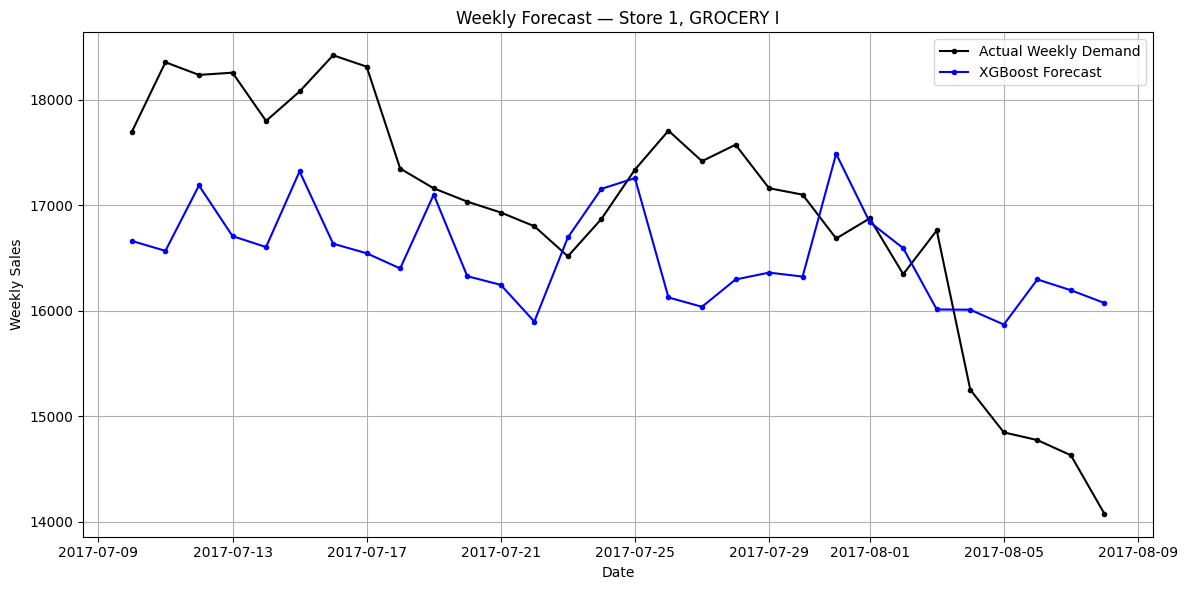

In [63]:
plt.figure(figsize=(12, 6))
plt.plot(df["ds"][-30:], y_test.values, 'k.-', label='Actual Weekly Demand')
plt.plot(df["ds"][-30:], y_pred, 'b.-', label='XGBoost Forecast')
plt.title("Weekly Forecast — Store 1, GROCERY I")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Monthly Forecast - MAE: 2597.22, RMSE: 2941.86


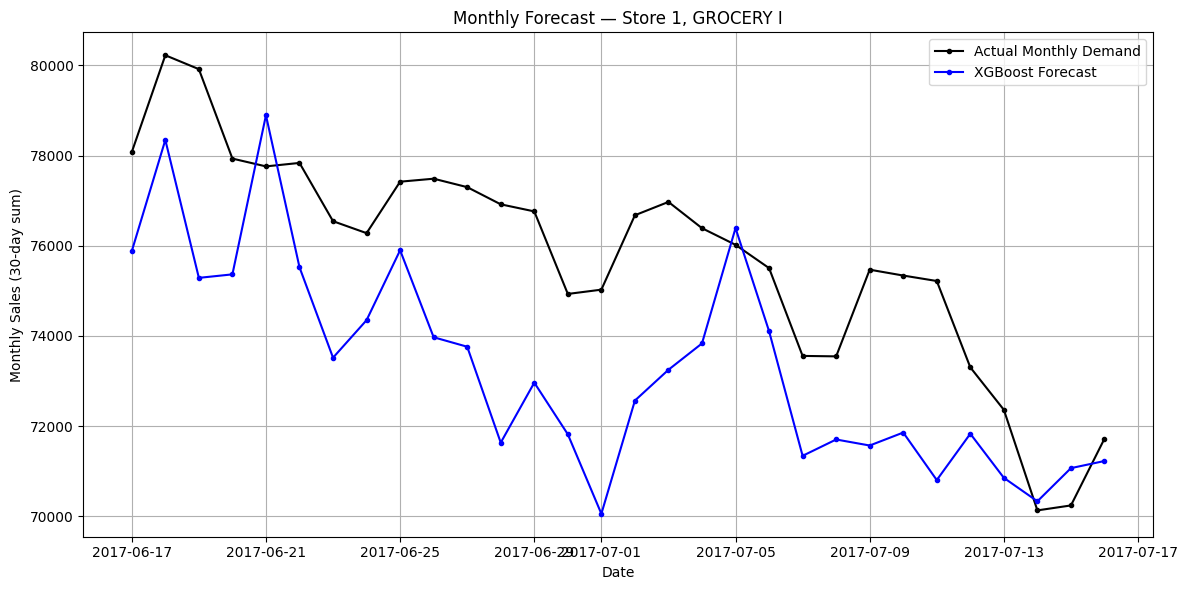

In [64]:
## Monthly forecast for one Family--Store pair

df = pd.read_csv("..////data//processed/cleaned_train.csv", parse_dates=["date"])
df = df[(df["store_nbr"] == 1) & (df["family"] == "GROCERY I")]
df = df.sort_values("date").reset_index(drop=True)
df.rename(columns={"date": "ds", "sales": "y"}, inplace=True)

# Monthly target = sum of next 30 days of sales
df["monthly_target"] = df["y"].rolling(window=30, min_periods=30).sum().shift(-30)
df = df.dropna(subset=["monthly_target"]).reset_index(drop=True)

# Lag and rolling features
df["sales_lag_7"] = df["y"].shift(7)
df["sales_lag_14"] = df["y"].shift(14)
df["rolling_mean_7"] = df["y"].rolling(window=7).mean().shift(1)
df["rolling_std_7"] = df["y"].rolling(window=7).std().shift(1)
df = df.dropna().reset_index(drop=True)

from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# Feature columns
feature_cols = [
    "onpromotion", "transactions", "is_perishable", "shelf_life_days", "is_holiday",
    "day_of_week", "month", "week", "is_weekend", "is_month_start", "is_month_end",
    "sales_lag_7", "sales_lag_14", "rolling_mean_7", "rolling_std_7"
]

X = df[feature_cols]
y = df["monthly_target"]

# Hold out last 30 days (similar to Prophet’s forecasting period)
X_train, X_test = X[:-30], X[-30:]
y_train, y_test = y[:-30], y[-30:]

# Train
model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Monthly Forecast - MAE: {mae:.2f}, RMSE: {rmse:.2f}")

plt.figure(figsize=(12, 6))
plt.plot(df["ds"][-30:], y_test.values, 'k.-', label='Actual Monthly Demand')
plt.plot(df["ds"][-30:], y_pred, 'b.-', label='XGBoost Forecast')
plt.title("Monthly Forecast — Store 1, GROCERY I")
plt.xlabel("Date")
plt.ylabel("Monthly Sales (30-day sum)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#### Although XGBoost is well-suited for retail forecasting due to its scalability and ability to leverage rich regressors, it underperformed in this case. Prophet’s time-aware modeling of seasonality and holidays proved more effective for our demand forecasting needs.

# SARIMA

In [65]:
## Reset

# Load and filter
df = pd.read_csv("..///data/processed/cleaned_train.csv", parse_dates=["date"])
df = df[(df["store_nbr"] == 1) & (df["family"] == "GROCERY I")]
df = df.sort_values("date").reset_index(drop=True)

# Aggregate daily sales
df.rename(columns={"date": "ds", "sales": "y"}, inplace=True)
ts = df.set_index("ds")["y"]

In [66]:
## pmdarima (auto_arima) is used to automatically select the best seasonal ARIMA parameters based on AIC
import pmdarima as pm

### For Backtesting

# Use all data except last 30 days for training
train_ts = ts[:-30]
test_ts = ts[-30:]  # Ground truth

# Fit SARIMA on train set
import pmdarima as pm
model = pm.auto_arima(
    train_ts,
    seasonal=True,
    m=7,
    d=1, D=1,
    trace=False,
    suppress_warnings=True,
    stepwise=True
)


In [67]:
n_periods = 30
sarima_forecast = model.predict(n_periods=n_periods)

# Dates to match test set
forecast_dates = pd.date_range(start=test_ts.index[0], periods=n_periods)
forecast_df = pd.DataFrame({"ds": forecast_dates, "yhat": sarima_forecast})


In [68]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
comparison = forecast_df.copy()
comparison["actual"] = test_ts.values

mae = mean_absolute_error(comparison["actual"], comparison["yhat"])
rmse = mean_squared_error(comparison["actual"], comparison["yhat"], squared=False)

print(f"SARIMA Backtest - MAE: {mae:.2f}, RMSE: {rmse:.2f}")



SARIMA Backtest - MAE: 232.52, RMSE: 366.93


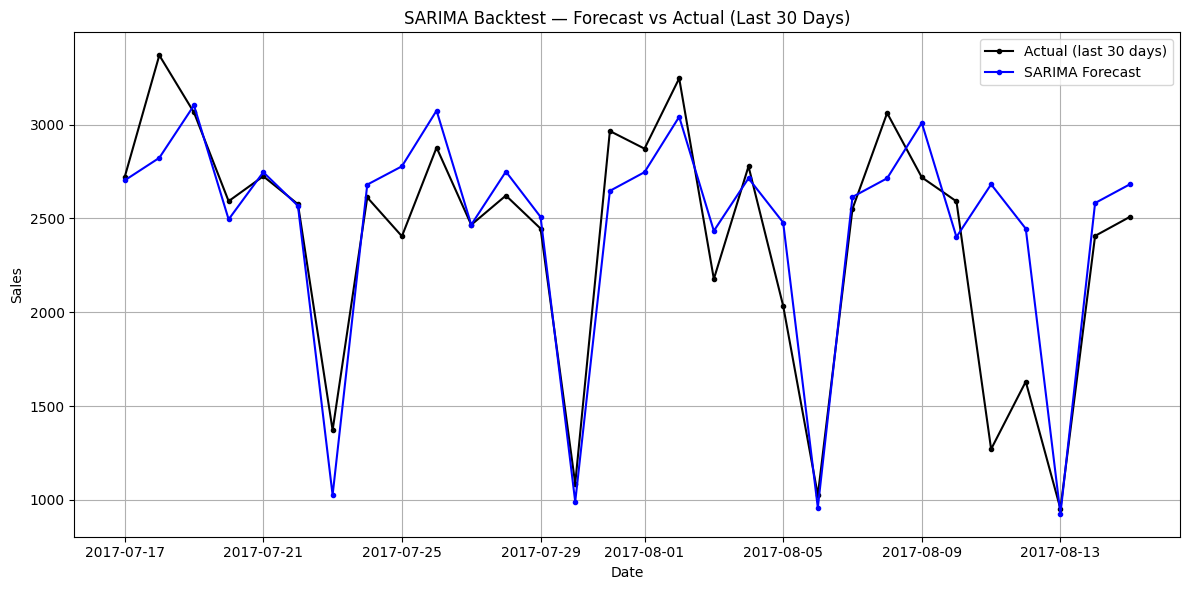

In [69]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(test_ts.index, test_ts.values, 'k.-', label='Actual (last 30 days)')
plt.plot(forecast_df["ds"], forecast_df["yhat"], 'b.-', label='SARIMA Forecast')
plt.title("SARIMA Backtest — Forecast vs Actual (Last 30 Days)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


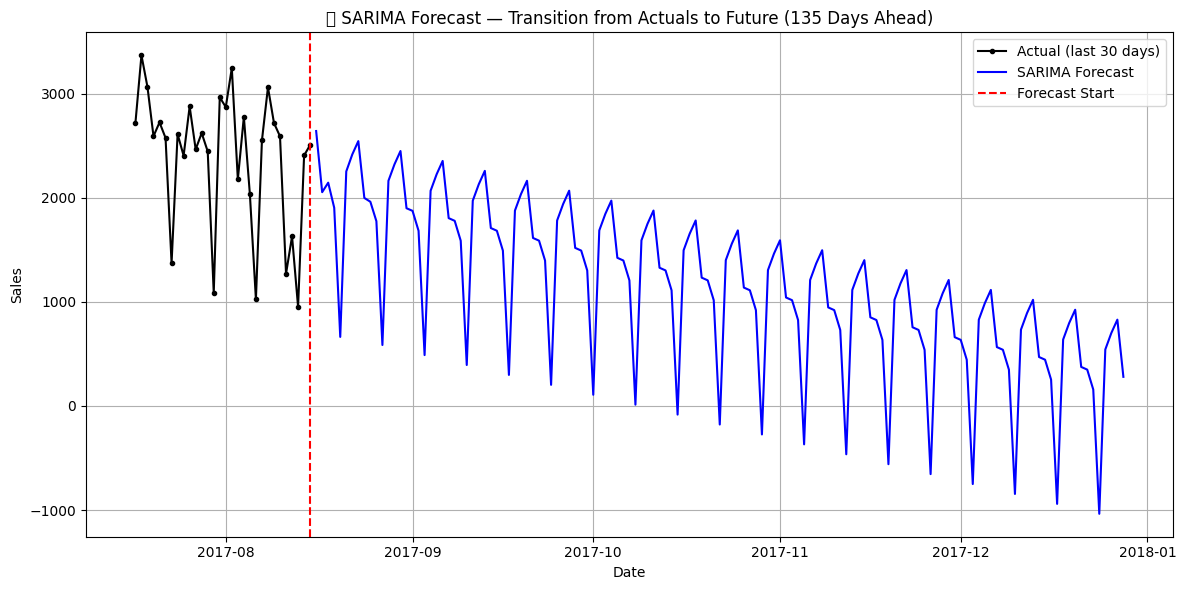

In [70]:
## 135 days Forecast

# STEP 1: Fit SARIMA on full available data
full_model = pm.auto_arima(
    ts,
    seasonal=True,
    m=7,
    d=1, D=1,
    trace=False,
    suppress_warnings=True,
    stepwise=True
)

# STEP 2: Forecast next 135 days
n_future = 135
future_forecast = full_model.predict(n_periods=n_future)

# Forecast dates
forecast_dates = pd.date_range(start=ts.index[-1] + pd.Timedelta(days=1), periods=n_future)

# Create forecast DataFrame
forecast_df = pd.DataFrame({
    "ds": forecast_dates,
    "yhat": future_forecast
})

# STEP 3: Extract actuals from the last 30 days
actual_recent = ts[-30:]
actual_df = pd.DataFrame({
    "ds": actual_recent.index,
    "y": actual_recent.values
})

# STEP 4: Plot actual + forecast transition
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(actual_df["ds"], actual_df["y"], 'k.-', label='Actual (last 30 days)')
plt.plot(forecast_df["ds"], forecast_df["yhat"], 'b-', label='SARIMA Forecast')
plt.axvline(x=ts.index[-1], color='r', linestyle='--', label='Forecast Start')
plt.title("🔮 SARIMA Forecast — Transition from Actuals to Future (135 Days Ahead)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [71]:
## SARIMAX

# Loading full cleaned dataset
df = pd.read_csv("../data/processed/cleaned_train.csv", parse_dates=["date"])
df = df[df["store_nbr"] == 1]
df = df[df["family"] == "GROCERY I"]
df = df.sort_values("date").reset_index(drop=True)

# Select relevant columns
df = df[["date", "sales", "onpromotion", "transactions", "is_holiday", "is_weekend", "month", "is_month_end"]]
df = df.rename(columns={"date": "ds", "sales": "y"})
df.set_index("ds", inplace=True)


In [72]:
# Split into train/test
train = df.iloc[:-30]
test = df.iloc[-30:]

# Targets and regressors
y_train = train["y"]
X_train = train.drop(columns="y")
y_test = test["y"]
X_test = test.drop(columns="y")

from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit model with exogenous variables
sarimax_model = SARIMAX(
    y_train,
    exog=X_train,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 7),
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarimax_result = sarimax_model.fit(disp=False)

# Forecast 30 days ahead using test exogenous vars
y_pred = sarimax_result.forecast(steps=30, exog=X_test)

# Evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print(f"SARIMAX Backtest - MAE: {mae:.2f}, RMSE: {rmse:.2f}")



SARIMAX Backtest - MAE: 249.39, RMSE: 296.07


In [73]:


# Full dataset for training
y_full = df["y"]
X_full = df.drop(columns="y")

# Fit SARIMAX on all data
sarimax_full_model = SARIMAX(
    y_full,
    exog=X_full,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 7),
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarimax_full_result = sarimax_full_model.fit(disp=False)

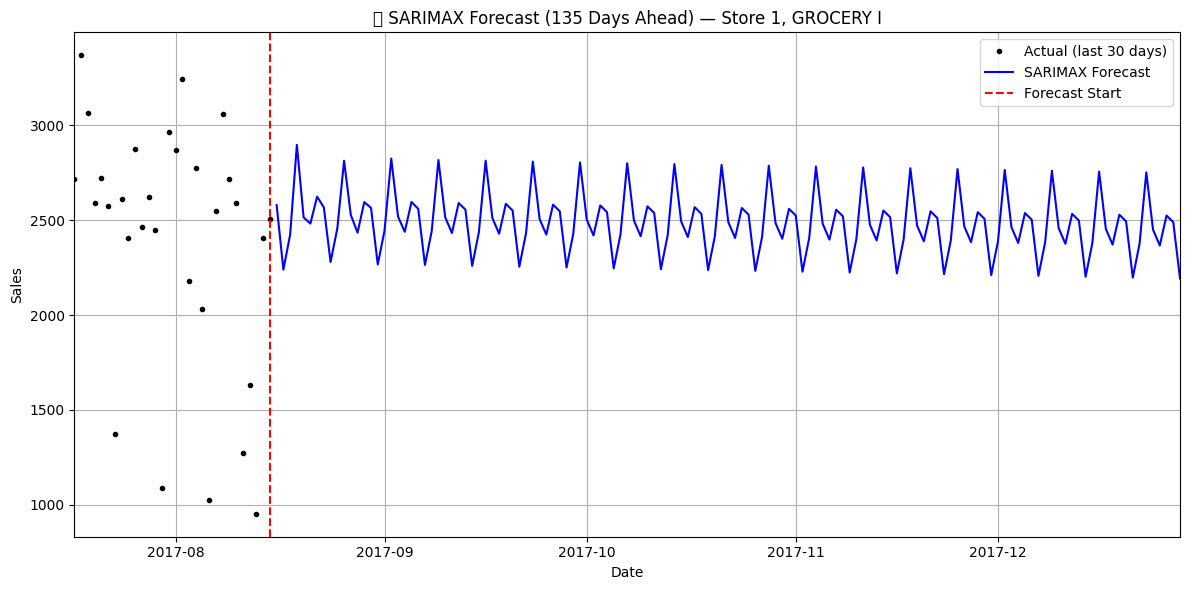

In [74]:
import pandas as pd

# Create future dates
n_future = 135
future_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=n_future)

# Use latest known regressor values for all future days
latest_regressors = X_full.iloc[-1]
X_future = pd.DataFrame([latest_regressors] * n_future, columns=X_full.columns, index=future_dates)

# Forecast
y_future_pred = sarimax_full_result.forecast(steps=n_future, exog=X_future)

# Forecast dataframe
forecast_df = pd.DataFrame({
    "ds": future_dates,
    "yhat": y_future_pred
})

actual_recent = df[-30:].copy().reset_index()
actual_recent = actual_recent.rename(columns={"date": "ds"})

plt.figure(figsize=(12, 6))
plt.plot(actual_recent["ds"], actual_recent["y"], 'k.', label='Actual (last 30 days)')
plt.plot(forecast_df["ds"], forecast_df["yhat"], 'b-', label='SARIMAX Forecast')
plt.axvline(x=actual_recent["ds"].max(), color='r', linestyle='--', label='Forecast Start')
plt.xlim([actual_recent["ds"].min(), forecast_df["ds"].max()])
plt.title("📈 SARIMAX Forecast (135 Days Ahead) — Store 1, GROCERY I")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#### SARIMAX with exogenous regressors showed strong performance in backtesting (MAE ≈ 249), outperforming SARIMA and XGBoost. However, its long-range forecast lacks realistic variation, likely due to static future regressors and inherent linearity. This can be addressed by injecting realistic future external features or switching to more dynamic models like Prophet or deep learning-based RNNs.

## Forecasting Model Comparison Summary

| Model      | Method Type                             | MAE                       | RMSE                      | Notes                                                                 |
|------------|------------------------------------------|---------------------------|---------------------------|-----------------------------------------------------------------------|
| **Prophet** | Additive time series + external regressors | **531.06**                | **748.51**                | Strong seasonality capture, flexible trend modeling, **best long-term forecast stability** |
| **XGBoost** | Supervised machine learning             | 975.26 (weekly)<br>2597.22 (monthly) | 1121.65 (weekly)<br>2941.86 (monthly) | Underperforms on temporal structure, **no real forecasting beyond known data** |
| **SARIMA**  | Classical time series                   | 232.52                    | 366.93                    | Simple and interpretable, decent short-term accuracy, **no external regressor support** |
| **SARIMAX** | Time series + exogenous regressors      | 249.39                    | 296.07                    | Strong backtest accuracy with regressors, but **future forecast looks overly smooth** |

---

### Model Selection Conclusion

- **Best Overall**: **Prophet**  
  Best suited for production deployment due to its flexibility, ability to integrate regressors, and robust future projections.

- **Best Short-Term Accuracy**: **SARIMA/SARIMAX**  
  Strong on recent data but struggles to generalize with static future inputs.

- **XGBoost** underperformed due to lack of inherent time awareness and forward extrapolation capability.
